In [1]:
import gc
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import scipy.cluster.hierarchy as shc

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
def get_clusters_info_elbow(data, center):
    kmeans = KMeans(n_clusters=center, max_iter=1000, random_state=42)
    kmeans.fit(data)
    score = kmeans.inertia_
    return score


def get_clusters_info_db(data, center):
    kmeans = KMeans(n_clusters=center, max_iter=1000, random_state=42)
    model = kmeans.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

### Load data

In [4]:
data = pd.read_parquet('data/riyadh.pq')

In [5]:
(data.peak_customer != data.peak_captain).sum()

612

In [6]:
data[data.peak_customer != data.peak_captain].head()

,booking_id,assignment_time,distance,duration,peak_captain,peak_customer,price
6627,1695991614,2023-02-01 08:46:53.000,6.80588,19,1.2,1.0,22.52
8331,1695881366,2023-02-01 05:22:31.000,3.64062,4,1.3,1.0,12.57
8536,1696230749,2023-02-01 13:34:50.000,2.53623,9,1.4,1.0,12.89
9144,1696103418,2023-02-01 11:28:35.000,2.39420,5,1.3,1.5,16.53
10634,1696967647,2023-02-02 13:25:57.000,2.57764,9,2.0,1.0,12.95


In [7]:
data = data.drop('peak_captain', axis=1)\
    .rename(columns={'peak_customer': 'peak'})

data = data[(data.distance <= 40.0) & (data.duration <= 60.0)]

In [8]:
data_np = data[data.peak == 1.0].copy()
data_peak = data[data.peak > 1.0].copy()

In [9]:
len(data_np)

456487

In [10]:
len(data_peak)

131618

In [11]:
data_np.head()

,booking_id,assignment_time,distance,duration,peak,price
1,1695907575,2023-02-01 06:08:06.000,7.46549,10,1.0,20.11
2,1695997244,2023-02-01 08:55:33.000,1.23862,3,1.0,10.93
3,1696458671,2023-02-01 19:01:42.000,6.37642,9,1.0,17.24
4,1696437981,2023-02-01 18:12:49.000,5.67880,12,1.0,8.69
5,1696134837,2023-02-01 11:58:23.000,11.99730,15,1.0,28.25


In [12]:
features = data_np[['distance', 'duration']].copy()
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features, columns=['distance', 'duration'])

### Selecting optimal K (No Peak)

100%|███████████████████████████████████████████| 28/28 [01:16<00:00,  2.74s/it]


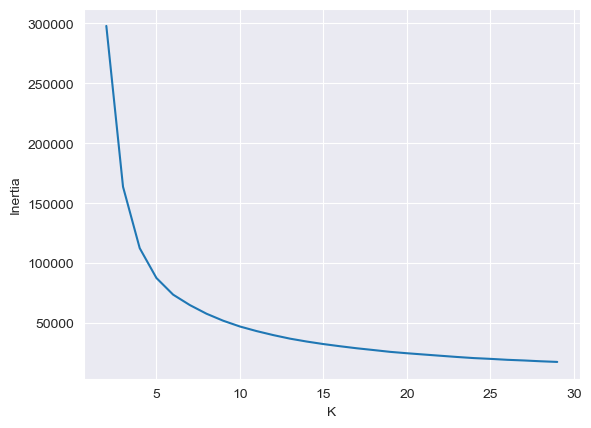

In [13]:
sse={}

for k in tqdm(range(2, 30)):
    sse[k] = get_clusters_info_elbow(features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("K")
plt.ylabel('Inertia')
plt.show()

100%|███████████████████████████████████████████| 28/28 [01:15<00:00,  2.71s/it]


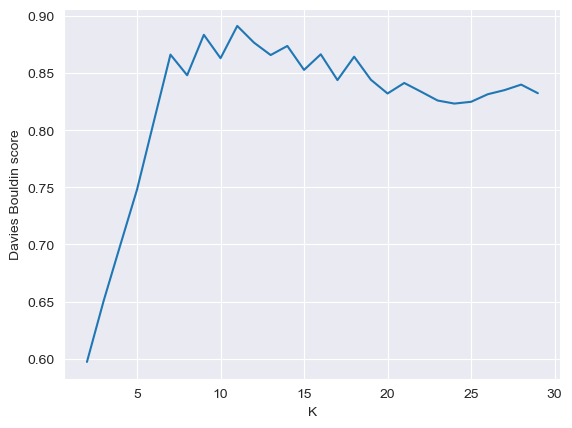

In [14]:
sse={}

for k in tqdm(range(2, 30)):
    sse[k] = get_clusters_info_db(features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.show()

### Clustering (No Peak)

In [59]:
kmeans = KMeans(n_clusters=9, max_iter=1000, random_state=42)
kmeans.fit(features)

data_np['cluster'] = kmeans.predict(features)

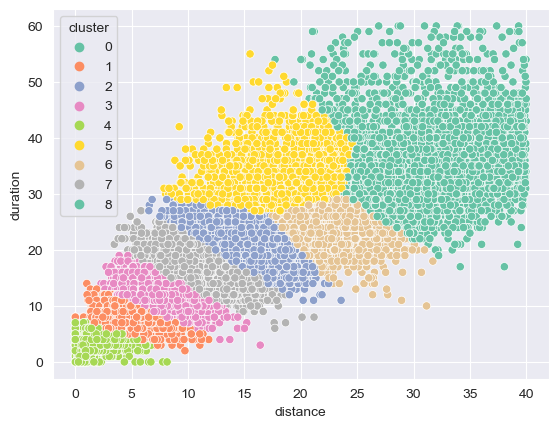

In [61]:
sns.scatterplot(data_np.sample(frac=0.2), x='distance', y='duration', hue='cluster', palette='Set2')
plt.savefig('pics/no_peak_9_clusters.png')

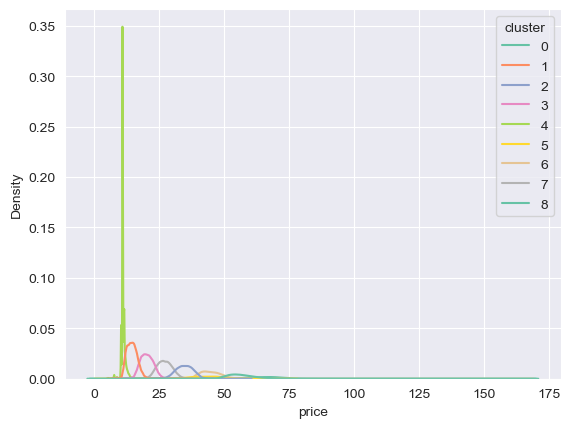

In [62]:
sns.kdeplot(data_np, x='price', hue='cluster', palette='Set2')
plt.savefig('pics/no_peak_9_clusters_prices.png')

In [63]:
kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=42)
kmeans.fit(features)

data_np['cluster'] = kmeans.predict(features)

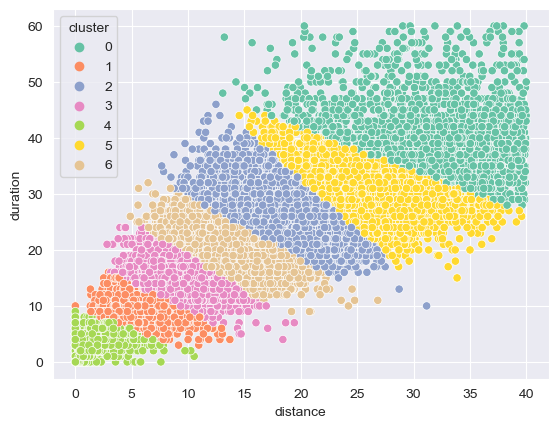

In [65]:
sns.scatterplot(data_np.sample(frac=0.2), x='distance', y='duration', hue='cluster', palette='Set2')
plt.savefig('pics/no_peak_7_clusters.png')

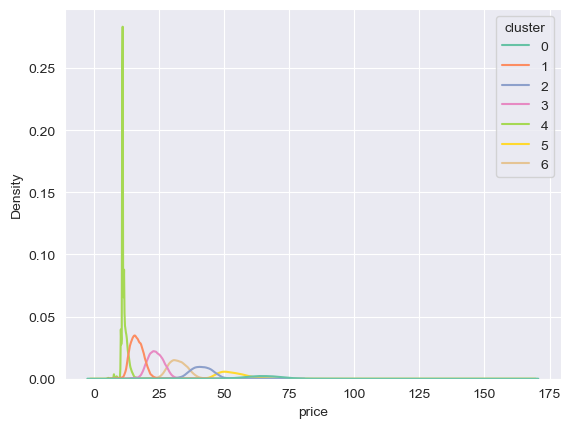

In [66]:
sns.kdeplot(data_np, x='price', hue='cluster', palette='Set2')
plt.savefig('pics/no_peak_7_clusters_prices.png')

In [70]:
data_np.cluster.value_counts(normalize=True)

4    0.230745
1    0.226381
3    0.179212
6    0.144407
2    0.109493
5    0.072179
0    0.037583
Name: cluster, dtype: float64

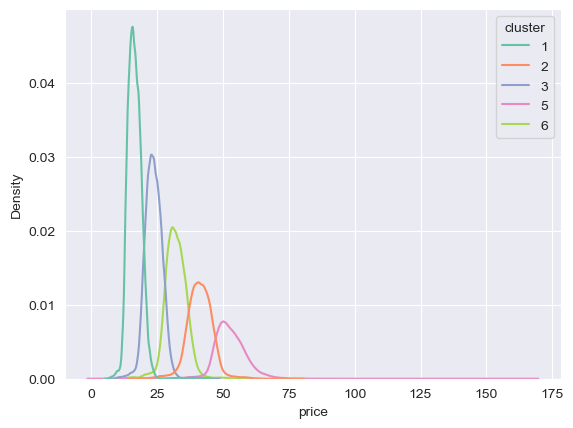

In [68]:
sns.kdeplot(data_np[~data_np.cluster.isin([4, 0])], x='price', hue='cluster', palette='Set2')
plt.savefig('pics/no_peak_7_clusters_prices_reduced.png')

In [20]:
def q_low(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    return x.quantile(0.25) - (1.5*iqr)

def q_high(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    return x.quantile(0.75) + (1.5*iqr)

ranges = data_np[['cluster', 'price']]\
    .groupby(by='cluster')\
    .agg(['mean', q_low, q_high])\
    .droplevel(axis=1, level=0)\
    .reset_index(drop=False)

In [21]:
ranges

,cluster,mean,q_low,q_high
0,0,64.579318,46.090000,83.130000
1,1,16.460132,9.340000,23.420000
2,2,41.200488,29.319998,53.160003
3,3,23.699540,15.045001,32.285000
4,4,11.533195,9.340000,13.580000
5,5,52.821992,38.160000,67.040000
6,6,32.119885,21.805000,42.405001


In [22]:
ranges['max'] = ranges['q_high']/ranges['mean']
ranges['min'] = ranges['q_low']/ranges['mean']

In [23]:
ranges

,cluster,mean,q_low,q_high,max,min
0,0,64.579318,46.090000,83.130000,1.287254,0.713696
1,1,16.460132,9.340000,23.420000,1.422832,0.567432
2,2,41.200488,29.319998,53.160003,1.290276,0.711642
3,3,23.699540,15.045001,32.285000,1.362263,0.634822
4,4,11.533195,9.340000,13.580000,1.177471,0.809836
5,5,52.821992,38.160000,67.040000,1.269168,0.722426
6,6,32.119885,21.805000,42.405001,1.320210,0.678863


In [24]:
# p_ranges = ranges[~ranges.cluster.isin([4, 6, 2])]

In [25]:
ranges['min'].mean()

0.6912453938155136

In [26]:
ranges['max'].mean()

1.3042106005011764

In [27]:
ranges_list = [{'peak': 1.0, 'min': ranges['min'].mean(), 'max': ranges['max'].mean()}]

### Peak

In [28]:
data_peak.peak.value_counts().sort_index(axis=0)

1.1    10184
1.2    16866
1.3    30894
1.4    28099
1.5    16422
1.6     7200
1.7     5159
1.8     4401
1.9     2719
2.0     4299
2.1     1133
2.2     4242
Name: peak, dtype: int64

In [29]:
PEAK = 2.0

data_peak_s = data_peak[data_peak.peak == PEAK].copy()
peak_features = data_peak_s[['distance', 'duration']].copy()

scaler = StandardScaler()
peak_features = scaler.fit_transform(peak_features)
peak_features = pd.DataFrame(peak_features, columns=['distance', 'duration'])

<AxesSubplot: xlabel='distance', ylabel='duration'>

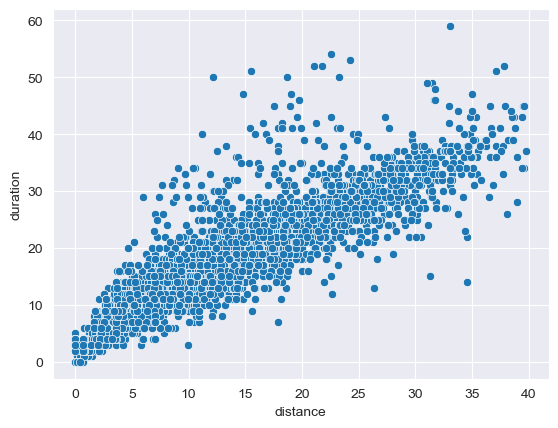

In [30]:
sns.scatterplot(data_peak_s, x='distance', y='duration')

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.67it/s]


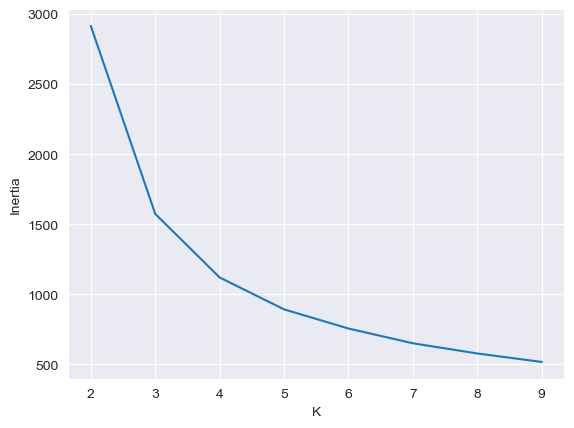

In [31]:
sse={}

for k in tqdm(range(2, 10)):
    sse[k] = get_clusters_info_elbow(peak_features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("K")
plt.ylabel('Inertia')
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.97it/s]


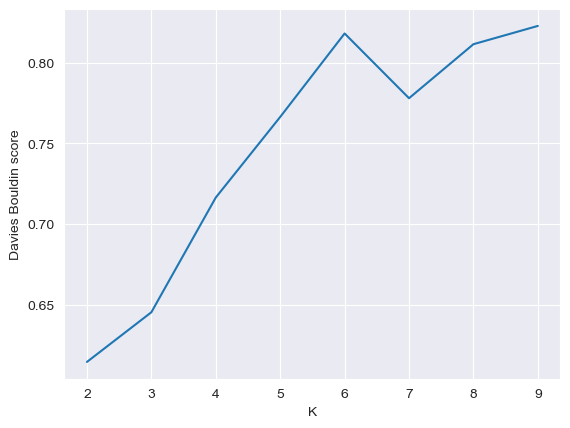

In [32]:
sse={}

for k in tqdm(range(2, 10)):
    sse[k] = get_clusters_info_db(peak_features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=42)
kmeans.fit(peak_features)

data_peak_s['cluster'] = kmeans.predict(peak_features)

<AxesSubplot: xlabel='distance', ylabel='duration'>

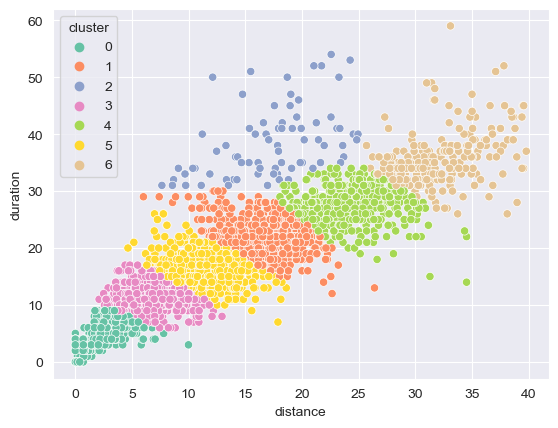

In [34]:
sns.scatterplot(data_peak_s, x='distance', y='duration', hue='cluster', palette='Set2')

<AxesSubplot: xlabel='price', ylabel='Density'>

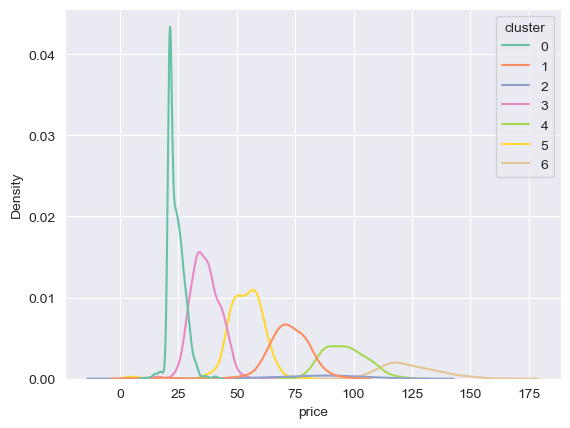

In [35]:
sns.kdeplot(data_peak_s, x='price', hue='cluster', palette='Set2')

In [36]:
peak_ranges = data_peak_s[['cluster', 'price']]\
    .groupby(by='cluster')\
    .agg(['mean', q_low, q_high, 'std'])\
    .droplevel(axis=1, level=0)\
    .reset_index(drop=False)

peak_ranges['max'] = peak_ranges['q_high']/peak_ranges['mean']
peak_ranges['min'] = peak_ranges['q_low']/peak_ranges['mean']

In [37]:
peak_ranges['min'].mean()

0.6307576597353003

In [38]:
peak_ranges['max'].mean()

1.3722760975376076

In [39]:
peak_ranges

,cluster,mean,q_low,q_high,std,max,min
0,0,24.030515,14.102500,33.242500,3.396749,1.383345,0.586858
1,1,71.815444,50.627500,94.607500,10.547483,1.317370,0.704967
2,2,83.415132,40.141256,129.711247,19.067108,1.555009,0.481223
3,3,36.681005,19.604998,53.645003,5.980693,1.462474,0.534473
4,4,95.788300,68.985000,122.305000,10.175929,1.276826,0.720182
5,5,53.917186,34.758750,73.468750,8.019959,1.362622,0.644669
6,6,123.675473,91.882500,154.382500,12.342319,1.248287,0.742932


In [40]:
for peak_value in tqdm(np.sort(data_peak.peak.unique())):
    data_peak_s = data_peak[data_peak.peak == peak_value].copy()
    peak_features = data_peak_s[['distance', 'duration']].copy()

    scaler = StandardScaler()
    peak_features = scaler.fit_transform(peak_features)
    peak_features = pd.DataFrame(peak_features, columns=['distance', 'duration'])
    
    kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=42)
    kmeans.fit(peak_features)

    data_peak_s['cluster'] = kmeans.predict(peak_features)
    
    peak_ranges = data_peak_s[['cluster', 'price']]\
        .groupby(by='cluster')\
        .agg(['mean', q_low, q_high])\
        .droplevel(axis=1, level=0)\
        .reset_index(drop=False)
    
    # peak_ranges = peak_ranges[(peak_ranges['mean'] > peak_ranges['mean'].min()) & (peak_ranges['mean'] < peak_ranges['mean'].max())]

    peak_ranges['max'] = peak_ranges['q_high']/peak_ranges['mean']
    peak_ranges['min'] = peak_ranges['q_low']/peak_ranges['mean']
    ranges_list.append({'peak': peak_value, 'min': peak_ranges['min'].mean(), 'max': peak_ranges['max'].mean()})

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


In [41]:
ranges_data = pd.DataFrame(ranges_list)

In [42]:
ranges_data

,peak,min,max
0,1.0,0.691245,1.304211
1,1.1,0.707683,1.289178
2,1.2,0.705401,1.294214
3,1.3,0.686636,1.317991
4,1.4,0.685001,1.316523
5,1.5,0.640178,1.363034
6,1.6,0.626407,1.372027
7,1.7,0.634182,1.367887
8,1.8,0.642100,1.371218
9,1.9,0.644553,1.362060


In [43]:
ranges_melted = ranges_data.set_index('peak', drop=True).unstack().reset_index(drop=False)

(0.5, 1.5)

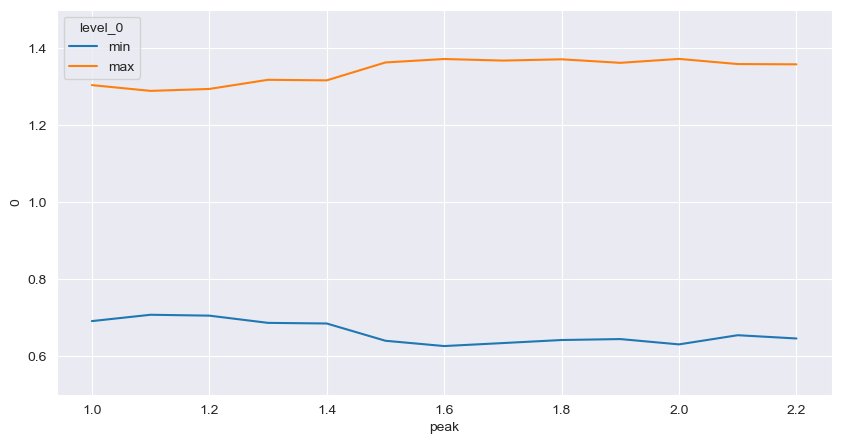

In [44]:
plt.figure(figsize=(10, 5))
sns.lineplot(ranges_melted, x='peak', y=0, hue='level_0')
plt.ylim(0.5, 1.5)

### Function

In [45]:
from scipy.interpolate import interp1d

In [46]:
def calmer_max(peak_factors: np.array) -> (float, float):
    x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0]) # [1.0, 1.1, 1.5, 3.0, 4.0]
    y = np.array([1.30, 1.27, 1.18, 1.11, 1.07, 1.05, 1.02, 1.0]) # [1.25, 1.248, 1.2, 1.08, 1.05]
    inperp_f = interp1d(x, y, kind='cubic')
    return inperp_f(peak_factors)


def calmer_min(peak_factors: np.array) -> (float, float):
    x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0]) # [1.0, 1.1, 1.5, 3.0, 4.0]
    y = np.array([0.75, 0.77, 0.81, 0.83, 0.85, 0.875, 0.9, 1.0]) # [0.75, 0.752, 0.8, 0.90, 0.92]
    inperp_f = interp1d(x, y, kind='cubic')
    return inperp_f(peak_factors)

In [47]:
calmed = pd.DataFrame(np.sort(data.peak.unique()), columns=['peak'])
dummy = pd.DataFrame([4.0], columns=['peak'])
calmed = pd.concat([calmed, dummy])
calmed['max'] = calmer_max(calmed['peak'].values)
calmed['min'] = calmer_min(calmed['peak'].values)

calmed_melted = calmed.set_index('peak', drop=True)\
    .unstack()\
    .reset_index(drop=False)\
    .rename(columns={'level_0': 'type', 0: 'relative bound'})

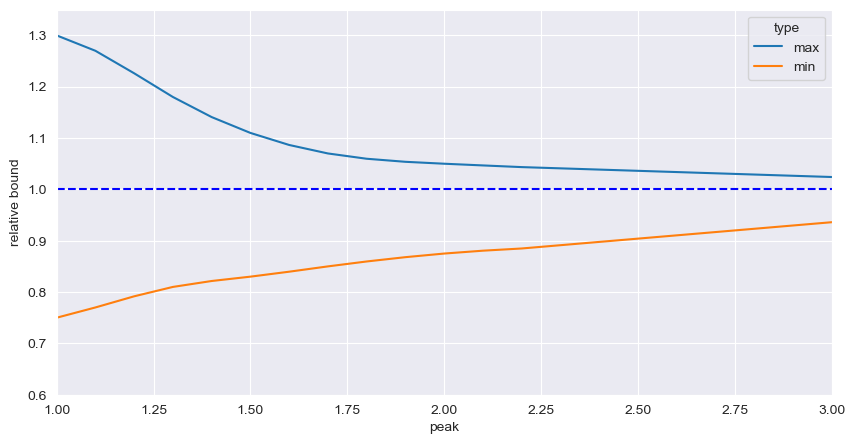

In [48]:
plt.figure(figsize=(10, 5))
a = sns.lineplot(calmed_melted, x='peak', y='relative bound', hue='type')
a.set(ylim=(0.6, 1.35), xlim=(1.0, 3.0))
a.axhline(y=1.0, color='blue', linestyle='--')
plt.savefig('function.png')

In [49]:
def price_suggester(sp: float, peak_factor: float) -> np.ndarray:
    upper = float(calmer_max(peak_factor))
    lower = float(calmer_min(peak_factor))
    
    inter_upper = 1.0 + ((upper - 1.0)/2)
    inter_lower = 1.0 - ((1.0 - lower)/2)
    
    return np.array([
        round(lower*sp, 2),
        round(inter_lower*sp, 2),
        round(sp, 2),
        round(inter_upper*sp, 2),
        round(upper*sp, 2),
    ])

In [50]:
price_suggester(150, 2.0)

array([131.25, 140.62, 150.  , 153.75, 157.5 ])

In [51]:
import typing
from scipy.interpolate import interp1d


class PriceSuggester(object):
    @staticmethod
    def _calmer_max() -> typing.Callable:
        x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0])
        y = np.array([1.30, 1.27, 1.18, 1.11, 1.07, 1.05, 1.02, 1.0])
        return interp1d(x, y, kind='cubic')

    @staticmethod
    def _calmer_min() -> typing.Callable:
        x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0])
        y = np.array([0.75, 0.77, 0.81, 0.83, 0.85, 0.875, 0.9, 1.0])
        return interp1d(x, y, kind='cubic')
    
    def get_bounds(self, peak_factor: float) -> (float, float):
        upper = float(self._calmer_max()(peak_factor))
        lower = float(self._calmer_min()(peak_factor))
        return (lower, upper)
    
    def suggest(self, sp: float, peak_factor: float) -> np.ndarray:
        lower, upper = self.get_bounds(peak_factor)

        inter_upper = 1.0 + ((upper - 1.0)/2)
        inter_lower = 1.0 - ((1.0 - lower)/2)

        return np.array([
            round(lower*sp, 2),
            round(inter_lower*sp, 2),
            round(sp, 2),
            round(inter_upper*sp, 2),
            round(upper*sp, 2),
        ])

### Sim

In [52]:
clusters = ranges[['mean']]\
    .sort_values(by='mean')\
    .reset_index(drop=True)\
    .reset_index(drop=False)\
    .rename(columns={'index': 'cluster'})

In [53]:
clusters['mean'] = round(clusters['mean'], 2)

In [54]:
for peak_value in tqdm(np.sort(data.peak.unique())):
    ps = PriceSuggester()
    bounds = tuple([round(x, 4) for x in ps.get_bounds(peak_value)])
    clusters[f'peak: {peak_value} | bounds: {bounds}'] = [str(ps.suggest(peak_value*x, peak_value).tolist()) for x in clusters['mean'].values]

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 401.72it/s]


In [55]:
clusters

,cluster,mean,"peak: 1.0 | bounds: (0.75, 1.3)","peak: 1.1 | bounds: (0.77, 1.27)","peak: 1.2 | bounds: (0.7917, 1.2262)","peak: 1.3 | bounds: (0.81, 1.18)","peak: 1.4 | bounds: (0.8215, 1.1409)","peak: 1.5 | bounds: (0.83, 1.11)","peak: 1.6 | bounds: (0.8397, 1.0865)","peak: 1.7 | bounds: (0.85, 1.07)","peak: 1.8 | bounds: (0.8596, 1.0597)","peak: 1.9 | bounds: (0.868, 1.0537)","peak: 2.0 | bounds: (0.875, 1.05)","peak: 2.1 | bounds: (0.8806, 1.0467)","peak: 2.2 | bounds: (0.8849, 1.0434)"
0,0,11.53,"[8.65, 10.09, 11.53, 13.26, 14.99]","[9.77, 11.22, 12.68, 14.4, 16.11]","[10.95, 12.4, 13.84, 15.4, 16.97]","[12.14, 13.57, 14.99, 16.34, 17.69]","[13.26, 14.7, 16.14, 17.28, 18.42]","[14.35, 15.82, 17.29, 18.25, 19.2]","[15.49, 16.97, 18.45, 19.25, 20.04]","[16.66, 18.13, 19.6, 20.29, 20.97]","[17.84, 19.3, 20.75, 21.37, 21.99]","[19.01, 20.46, 21.91, 22.5, 23.08]","[20.18, 21.62, 23.06, 23.64, 24.21]","[21.32, 22.77, 24.21, 24.78, 25.34]","[22.45, 23.91, 25.37, 25.92, 26.47]"
1,1,16.46,"[12.34, 14.4, 16.46, 18.93, 21.4]","[13.94, 16.02, 18.11, 20.55, 22.99]","[15.64, 17.69, 19.75, 21.99, 24.22]","[17.33, 19.37, 21.4, 23.32, 25.25]","[18.93, 20.99, 23.04, 24.67, 26.29]","[20.49, 22.59, 24.69, 26.05, 27.41]","[22.11, 24.22, 26.34, 27.48, 28.62]","[23.78, 25.88, 27.98, 28.96, 29.94]","[25.47, 27.55, 29.63, 30.51, 31.4]","[27.14, 29.21, 31.27, 32.11, 32.95]","[28.8, 30.86, 32.92, 33.74, 34.57]","[30.44, 32.5, 34.57, 35.37, 36.18]","[32.04, 34.13, 36.21, 37.0, 37.78]"
2,2,23.70,"[17.77, 20.74, 23.7, 27.25, 30.81]","[20.07, 23.07, 26.07, 29.59, 33.11]","[22.52, 25.48, 28.44, 31.66, 34.87]","[24.96, 27.88, 30.81, 33.58, 36.36]","[27.26, 30.22, 33.18, 35.52, 37.85]","[29.51, 32.53, 35.55, 37.51, 39.46]","[31.84, 34.88, 37.92, 39.56, 41.2]","[34.25, 37.27, 40.29, 41.7, 43.11]","[36.67, 39.66, 42.66, 43.93, 45.21]","[39.08, 42.06, 45.03, 46.24, 47.45]","[41.47, 44.44, 47.4, 48.58, 49.77]","[43.83, 46.8, 49.77, 50.93, 52.09]","[46.14, 49.14, 52.14, 53.27, 54.4]"
3,3,32.12,"[24.09, 28.1, 32.12, 36.94, 41.76]","[27.21, 31.27, 35.33, 40.1, 44.87]","[30.52, 34.53, 38.54, 42.9, 47.26]","[33.82, 37.79, 41.76, 45.51, 49.27]","[36.94, 40.96, 44.97, 48.14, 51.3]","[39.99, 44.08, 48.18, 50.83, 53.48]","[43.15, 47.27, 51.39, 53.62, 55.84]","[46.41, 50.51, 54.6, 56.52, 58.43]","[49.7, 53.76, 57.82, 59.54, 61.27]","[52.97, 57.0, 61.03, 62.67, 64.31]","[56.21, 60.22, 64.24, 65.85, 67.45]","[59.4, 63.42, 67.45, 69.03, 70.6]","[62.53, 66.6, 70.66, 72.2, 73.73]"
4,4,41.20,"[30.9, 36.05, 41.2, 47.38, 53.56]","[34.9, 40.11, 45.32, 51.44, 57.56]","[39.14, 44.29, 49.44, 55.03, 60.62]","[43.38, 48.47, 53.56, 58.38, 63.2]","[47.39, 52.53, 57.68, 61.74, 65.81]","[51.29, 56.55, 61.8, 65.2, 68.6]","[55.35, 60.64, 65.92, 68.77, 71.62]","[59.53, 64.79, 70.04, 72.49, 74.94]","[63.75, 68.95, 74.16, 76.37, 78.59]","[67.94, 73.11, 78.28, 80.38, 82.49]","[72.1, 77.25, 82.4, 84.46, 86.52]","[76.19, 81.35, 86.52, 88.54, 90.56]","[80.21, 85.42, 90.64, 92.61, 94.57]"
5,5,52.82,"[39.62, 46.22, 52.82, 60.74, 68.67]","[44.74, 51.42, 58.1, 65.95, 73.79]","[50.18, 56.78, 63.38, 70.55, 77.72]","[55.62, 62.14, 68.67, 74.85, 81.03]","[60.75, 67.35, 73.95, 79.16, 84.37]","[65.76, 72.5, 79.23, 83.59, 87.95]","[70.96, 77.74, 84.51, 88.17, 91.83]","[76.32, 83.06, 89.79, 92.94, 96.08]","[81.72, 88.4, 95.08, 97.91, 100.75]","[87.11, 93.73, 100.36, 103.05, 105.75]","[92.43, 99.04, 105.64, 108.28, 110.92]","[97.68, 104.3, 110.92, 113.51, 116.1]","[102.83, 109.52, 116.2, 118.73, 121.25]"
6,6,64.58,"[48.44, 56.51, 64.58, 74.27, 83.95]","[54.7, 62.87, 71.04, 80.63, 90.22]","[61.35, 69.42, 77.5, 86.26, 95.02]","[68.0, 75.98, 83.95, 91.51, 99.07]","[74.28, 82.34, 90.41, 96.78, 103.15]","[80.4, 88.64, 96.87, 102.2, 107.53]","[86.76, 95.04, 103.33, 107.8, 112.27]","[93.32, 101.55, 109.79, 113.63, 117.47]","[99.92, 108.08, 116.24, 119.71, 123.18]","[106.5, 114.6, 122.7, 126.0, 129.3]","[113.01, 121.09, 129.16, 132.39, 135.62]","[119.42, 127.52, 135.62, 138.78, 141.95]","[125.72, 133.9, 142.08, 145.

In [56]:
# clusters.to_csv('riyadh_suggestions.csv', index=False, sep=';')